In [2]:
import sys
sys.path.append("../")
import os
print(os.getcwd())
%pylab inline
import GPyOpt
import GPy
from AlphaOpt import components

/Users/tardis/Developer/nus/AlphaOpt/modelling
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Helper functions
def get_model_with(model, space, objective, a, e, x, c=None):
    return GPyOpt.methods.ModularBayesianOptimization(model=model,
                                                space=space,
                                                objective=objective,
                                                acquisition=a,
                                                evaluator=e,
                                                X_init=x,
                                                cost=c)

def get_diff_from_optimal_X(true, experimental):
    if(len(true) == 1):
        return (true-experimental)[0]
    min_pos1, min_pos2 = true[0], true[1]
    if (sum_ae(min_pos1, experimental) < sum_ae(min_pos2, experimental)):
        return (min_pos1-experimental)[0]
    else:
        return (min_pos2-experimental)[0]
        
def sum_ae(val1, val2): # Sum of absolute errors; or should we do Absolute sum of errors? :hm:
    return abs(val1[0] - val2[0]) + abs(val1[1] - val2[1])

def print_results(f=None, bl=None, *args):
    print("Baseline X's: {}".format(bl.x_opt))
    for i in range(len(args)):
        print("Model {} X's: {}".format(i, args[i].x_opt))
    print("Baseline best y(x): {}".format(bl.fx_opt))
    for i in range(len(args)):
        print("Model {} best y(x): {}".format(i, args[i].fx_opt))

    print("Baseline x_err: {}".format(get_diff_from_optimal_X(f.min, bl.x_opt)))
    for i in range(len(args)):
        print("Model {} x_err: {}".format(i, get_diff_from_optimal_X(f.min, args[i].x_opt)))

    errs = [f.f(bl.x_opt)]
    print("Baseline f_err: {}".format(f.f(bl.x_opt)))
    for i in range(len(args)):
        errs.append(f.f(args[i].x_opt))
        print("Model {} f_err: {}".format(i, f.f(args[i].x_opt)))
    errs = map(lambda x: math.sqrt(x*x), errs)
    print("Min abs. error = {}".format(min(errs)))


In [176]:
from GPyOpt.objective_examples.experiments2d import *

# Output
bounds=[(-0.5,3),(-1.5,2)]
func  = rosenbrock(bounds=bounds)
y = rosenbrock(bounds=bounds,sd=1.)
objective = GPyOpt.core.task.SingleObjective(lambda x: -y.f(x))

# Input
v1_dom, v2_dom = bounds[0], bounds[1]

space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': v1_dom}
                                    ,{'name': 'var_2', 'type': 'continuous', 'domain': v2_dom}])
X_init = GPyOpt.util.stats.initial_design('random', space, 5)

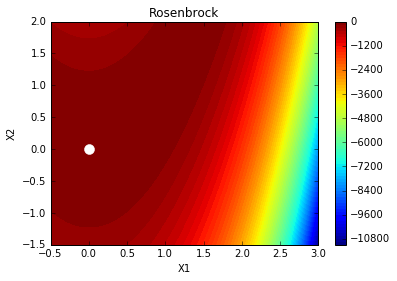

In [177]:
# The true function
func.plot()

In [191]:
# Bayesian Optimization Components
# GP models
kernel = GPy.kern.Matern52(input_dim=2, ARD=True)
model = GPyOpt.models.GPModel(kernel=kernel, optimize_restarts=10,verbose=False)

# Cost model
# cost = GPyOpt.core.task.CostModel('evaluation_time')

In [192]:
# Imports for Acquisition function
from GPyOpt.acquisitions import AcquisitionBase, AcquisitionEI
from GPyOpt.core.task.cost import constant_cost_withGradients
from GPyOpt.util.general import get_quantiles
import math
import numpy as np

In [214]:
class EIXplore(AcquisitionBase):   
    """
    General template to create a new GPyOPt acquisition function

    :param model: GPyOpt class of model
    :param space: GPyOpt class of domain
    :param optimizer: optimizer of the acquisition. Should be a GPyOpt optimizer
    :param cost_withGradients: function that provides the evaluation cost and its gradients

    """
    # --- Set this line to true if analytical gradients are available
    analytical_gradient_prediction = False
    
    jitter = 0
    
    explore = 0
    cycle = 3
    
    prev = None

    def __init__(self, model, space, optimizer, cost_withGradients=None, jitter=0.01, cycle=3):
        super(EIXplore, self).__init__(model, space, optimizer)

        self.jitter = jitter
        self.cycle = cycle
        if cost_withGradients == None:
             self.cost_withGradients = constant_cost_withGradients
        else:
             self.cost_withGradients = cost_withGradients 


    def _compute_acq(self,x):
        m, s = self.model.predict(x)
        fmin = self.model.get_fmin()
        phi, Phi, _ = get_quantiles(self.jitter, fmin, m, s)
        h = -0.5 * np.log(2*math.pi*math.e*np.square(s))
        if self.prev != None and abs(self.prev-fmin) < 1:
            self.prev = fmin
            return h
        
        self.prev = fmin
        f_acqu_x = h if (self.explore % self.cycle) == 0 else (fmin - m + self.jitter) * Phi + s * phi
        self.explore += 1
        self.explore %= self.cycle
        return f_acqu_x

In [215]:
class EntropyWeightedEI(AcquisitionBase):   
    """
    General template to create a new GPyOPt acquisition function

    :param model: GPyOpt class of model
    :param space: GPyOpt class of domain
    :param optimizer: optimizer of the acquisition. Should be a GPyOpt optimizer
    :param cost_withGradients: function that provides the evaluation cost and its gradients

    """
    # --- Set this line to true if analytical gradients are available
    analytical_gradient_prediction = False

    def __init__(self, model, space, optimizer, cost_withGradients=None):
        super(EntropyWeightedEI, self).__init__(model, space, optimizer)
        
        self.EI = AcquisitionEI(model, space, optimizer, cost_withGradients)

        if cost_withGradients == None:
             self.cost_withGradients = constant_cost_withGradients
        else:
             self.cost_withGradients = cost_withGradients 


    def _compute_acq(self,x):
        _, s = self.model.predict(x)
        acqu_x = self.EI.acquisition_function(x)
        h = -0.5 * np.log(2*math.pi*math.e*np.square(s))
        for i in range (acqu_x.shape[0]):
            acqu_x[i] -= h[i]
        return acqu_x

In [216]:
# Decision models
acq_opt = GPyOpt.optimization.AcquisitionOptimizer(space)

# Use EI as the baseline
acq_fxs = [GPyOpt.acquisitions.AcquisitionEI(model, space, acq_opt), 
          EIXplore(model, space, acq_opt, cycle=5),
          EntropyWeightedEI(model, space, acq_opt)]

eval_fxs = []
for i in range(len(acq_fxs)):
    eval_fxs.append(GPyOpt.core.evaluators.Sequential(acq_fxs[i]))

In [217]:
# Do BO for baseline and custom
models = []
for i in range(len(acq_fxs)):
    models.append(get_model_with(model, space, objective, acq_fxs[i], eval_fxs[i], X_init))

In [218]:
max_iter  = 25
for m in models:
    m.run_optimization(max_iter = max_iter, eps=1e-10, verbosity=True)

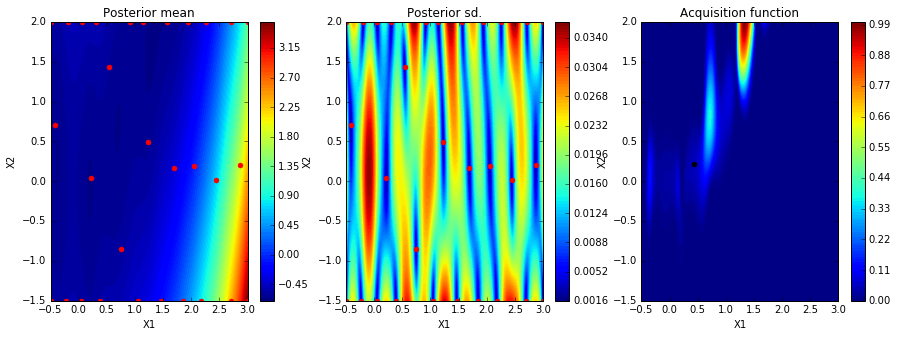

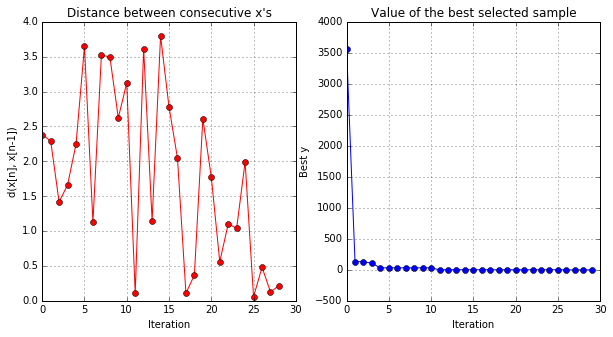

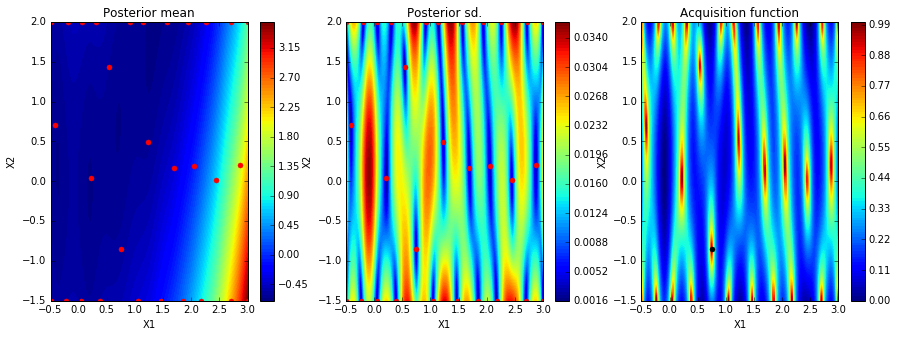

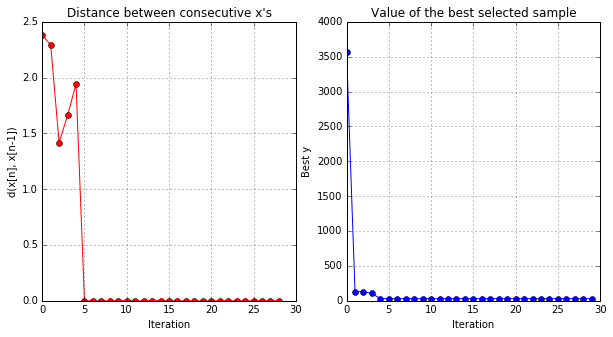

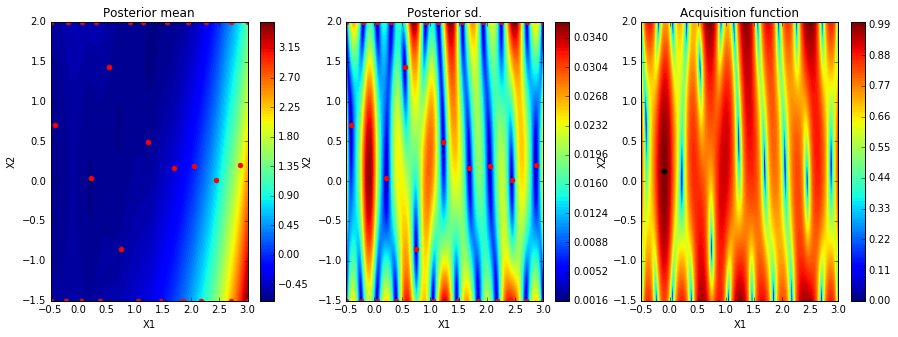

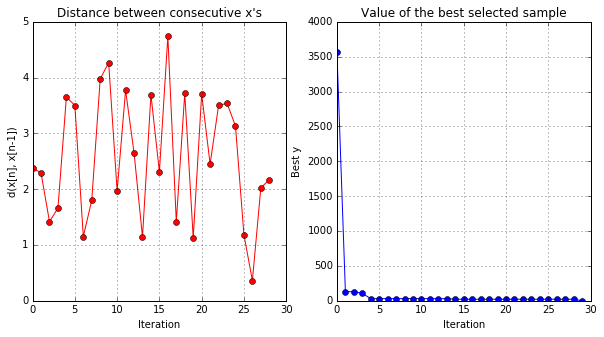

In [212]:
for m in models:
    m.plot_acquisition()
    m.plot_convergence()

In [213]:
print_results(func, *models)

Baseline X's: [ 0.22765244 -0.00023421]
Model 0 X's: [-0.41582193  0.71146235]
Model 1 X's: [ 0.21765246  0.0396837 ]
Baseline best y(x): [-1.92650547]
Model 0 best y(x): [ 30.52966527]
Model 1 best y(x): [ 1.38181336]
Baseline x_err: [-0.22765244  0.00023421]
Model 0 x_err: [ 0.41582193 -0.71146235]
Model 1 x_err: [-0.21765246 -0.0396837 ]
Baseline f_err: [[-0.86754352]]
Model 0 f_err: [[-31.00864348]]
Model 1 f_err: [[-0.61797958]]
Min abs. error = 0.6179795836853371
